# _k_-Nearest Neighbors (kNN)

In [1]:
import numpy as np

In [2]:
class KNN:
    def __init__(self, k):
        self.k = k
        
    def fit(self, X, y):
        self._X = X
        self._y = y
    
    def predict(self, X):
        y_pred = np.empty(len(X))
        for i, x in enumerate(X):
            dist = np.sum((self._X - x) ** 2, axis=1)
            idx = dist.argsort()[:self.k]
            
            k_classes = self._y[idx]
            counts = np.bincount(k_classes)
            ranks = counts.argsort()[::-1]
            y_pred[i] = ranks[0]
            
        return y_pred

In [3]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_std = np.copy(X)
X_std = sc.fit_transform(X_std)
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.33, random_state=0)

In [5]:
knn = KNN(k=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [6]:
from __future__ import division

def accuracy_score(y_true, y_pred):
    return (y_true == y_pred).sum() / len(y_pred)

score = accuracy_score(y_test, y_pred)
print("Accuracy: {}".format(score))

Accuracy: 0.96


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

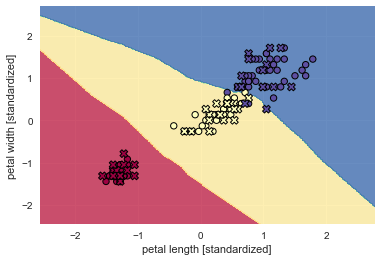

In [8]:
def make_meshgrid(x, y, h=0.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

X0, X1 = X_std[:, 0], X_std[:, 1]
xx, yy = make_meshgrid(X0, X1)

Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker='o',
            cmap=plt.cm.Spectral, s=40, edgecolor='k', linewidth=1)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='X',
            cmap=plt.cm.Spectral, s=60, edgecolor='k', linewidth=1)
plt.xlabel("petal length [standardized]")
plt.ylabel("petal width [standardized]")
plt.show()

# _k_-dimensional Tree (_k_-d Tree)

In [9]:
from collections import namedtuple
from pprint import pformat

## Buliding a Tree

In [10]:
class KDNode(namedtuple('Node', 'point left_child right_child')):
    """
    """
    def __repr__(self):
        return pformat(tuple(self))

In [11]:
def kdtree(data, depth=0):
    """Build k-dimensional tree
    """
    assert data.shape[1] == 2
    if data.shape[0] < 1:
        return None
    elif data.shape[0] == 1:
        return KDNode(point = data[0, :], left_child = None, right_child = None)
    else:
        axis = depth % data.shape[1]  # switch between split orientations
        idx_sort = np.argsort(data[:, axis])
        data = data[idx_sort, :]
        median = len(data) // 2
        return KDNode(point = data[median, :],
                      left_child = kdtree(data[:median, :], depth + 1),
                      right_child = kdtree(data[median + 1:, :], depth + 1))

## Nearest Neighbor

In [19]:
def nearest_neighbor_search(tree, query_point, depth=0):
    """recursively search nearest neighbor
    """
    assert tree is not None
    
    if tree.left_child is None:
        distance = ((tree.point - query_point) ** 2).sum()
        return tree.point, distance, 0
    
    else:
        axis = depth % query_point.shape[0]
        # print("Searching \"near\" subtree..")
        if query_point[axis] < tree.point[axis]:
            near_subtree = tree.left_child
        else:
            near_subtree = tree.right_child
        
        distance3 = ((tree.point - query_point) ** 2).sum()
 
        # print("Near subtree: {}".format(near_subtree))
        if near_subtree is None:
            return tree.point, distance3, 0
        
        else:
            best_neighbor, distance, height = nearest_neighbor_search(near_subtree, query_point, depth + 1)
            # print("Depth: {}".format(depth))
            # print("Height: {}".format(height))
            
            if height <= 2:
                # print("Searching \"far\" subtree..")
                if query_point[axis] < tree.point[axis]:
                    far_subtree = tree.right_child
                else:
                    far_subtree = tree.left_child
                
                if far_subtree is None:
                    return tree.point, distance3, 0
                
                else:
                    best_neighbor2, distance2, height2 = nearest_neighbor_search(far_subtree, query_point, depth + 1)
                    if distance3 < distance2:
                        distance2 = distance3
                        best_neighbor2 = tree.point

                    if distance2 < distance:
                        distance = distance2
                        best_neighbor = best_neighbor2
                    
            return best_neighbor, distance, height + 1

In [13]:
data = np.array([[5,4], [1, 6], [6, 1], [7, 5], [10, 14], [8, 3], [4, 3], [4, 6], [7, 6], [3, 5], [2, 7], [2, 2], [6, 8], [3, 9]])

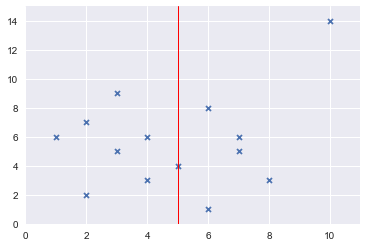

In [14]:
plt.scatter(data[:,0], data[:,1], s=25, marker='x')
plt.xlim(0, 11)
plt.ylim(0, 15)
plt.plot([5, 5], [0, 15], c='r', linewidth=1)

In [15]:
tree = kdtree(data)
tree

(array([5, 4]),
 (array([1, 6]),
 (array([3, 5]), (array([2, 2]), None, None), (array([4, 3]), None, None)),
 (array([3, 9]), (array([2, 7]), None, None), (array([4, 6]), None, None))),
 (array([7, 6]),
 (array([7, 5]), (array([6, 1]), None, None), (array([8, 3]), None, None)),
 (array([10, 14]), (array([6, 8]), None, None), None)))

In [16]:
def draw_split(tree, axis, xmin, xmax, ymin, ymax, point=[], depth=0):
    """
    """
    if depth == 0 and not point:
        point = [xmin, ymax]
    
    xmin_, xmax_ = xmin, xmax
    ymin_, ymax_ = ymin, ymax
    prev_axis = (axis - 1) % 2
    bound = point[prev_axis]
    
    coord = tree.point[axis]
    if axis == 0:
        if tree.point[prev_axis] < bound:
            line = plt.plot([coord, coord], [ymin, bound])
            ymax_ = bound
        else:
            line = plt.plot([coord, coord], [bound, ymax])
            ymin_ = bound
    else:
        if tree.point[prev_axis] < bound:
            line = plt.plot([xmin, bound], [coord, coord])
            xmax_ = bound
        else:
            line = plt.plot([bound, xmax], [coord, coord])
            xmin_ = bound

    if line:
        plt.setp(line, linewidth=1, linestyle='-', color='r')

    axis = (axis + 1) % 2
    depth += 1
    
    if tree.left_child is not None:
        draw_split(tree.left_child, axis, xmin_, xmax_, ymin_, ymax_, tree.point, depth)
        
    if tree.right_child is not None:
        draw_split(tree.right_child, axis, xmin_, xmax_, ymin_, ymax_, tree.point, depth)

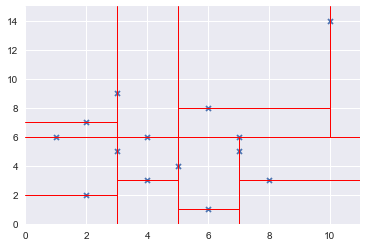

In [17]:
plt.scatter(data[:,0], data[:,1], s=25, marker='x')
plt.xlim(0, 11)
plt.ylim(0, 15)
draw_split(tree, 0, 0, 11, 0, 15)

In [18]:
nearest_neighbor_search(tree=tree, query_point=np.array([9, 9]))

Depth: 2
Height: 0
Depth: 1
Height: 0
Depth: 2
Height: 0
Depth: 0
Height: 1
Depth: 2
Height: 0
Depth: 1
Height: 1
Depth: 2
Height: 0


(array([7, 6]), 13, 2)